# **Sentiment Analysis using Movie Reviews**

## Overview
This notebook explores several approaches to sentiment analysis using built-in natural language processing methods from Python.  We will take a look at the `TextBlob` and `VADER` packages, as well as trying a pre-trained zero shot classification model from the `transformers` package.  

Our dataset contains 40k movie reviews with labels indicating negative sentiment as 0 and positive sentiment as 1.  More details can be found [here](https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis) via Kaggle.  To reduce our runtime, we will take a stratified random sample of 1k movie reviews, retaining the approximate 50/50 target distribution from the overall dataset.

## Contents
* Import Data
* Data Preparation
* TextBlob Sentiment Analysis
* VADER Sentiment Analysis
* Zero Shot Classification of Sentiment
* Quick Comparison using Correlation Matrix

## Outcome
The zero shot classifier produced a much higher correlation with the target sentiment label than the TextBlob and VADER methods on the raw data (see table below).  Interestingly, cleaning the text data appears to have hindered performance against the target label.  

| NLP Method           | Text Data | Correlation w/ Target |
|----------------------|-----------|-----------------------|
| TextBlob Sentiment   | Raw       | 0.55                  |
| TextBlob Sentiment   | Clean     | 0.51                  |
| VADER Sentiment      | Raw       | 0.43                  |
| VADER Sentiment      | Clean     | 0.41                  |
| Zero Shot Classifier | Raw       | 0.74                  |
| Zero Shot Classifier | Clean     | 0.55                  |

The kernel density estimate (KDE) plots for each method (in the notebook contents below) provide another perspective on performance, highlighting the zero shot classifier's ability to better distinguish between positive and negative sentiment at a prediction-level.  The major drawback of the zero shot analysis is that it takes far longer to compute than the other approaches.  TextBlob and VADER completed in seconds while the zero shot classifier took ~17 minutes (on an M1 Macbook Pro) on the raw text data.  

If prediction-level accuracy is paramount, then we should consider the zero shot approach.  However, if we're looking to track something like an average sentiment over time, then the TextBlob method would likely be sufficient.   

---
# **Environment**

In [1]:
# general usage
import pandas as pd
import numpy as np
import time
import re

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

# NLP data cleaning
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# sentiment analysis tools
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dustinweems/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dustinweems/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dustinweems/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/dustinweems/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

---
# **Import Data**

In [3]:
# load full dataset
reviews_df = pd.read_csv('movie.csv')

In [4]:
# take smaller stratified random sample
reviews_df = reviews_df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=500, random_state=22)).reset_index(drop=True)

In [5]:
# review data
reviews_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1000 non-null   object
 1   label   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [6]:
# check distribution of target sentiment label
reviews_df.label.value_counts(normalize=True)

0    0.5
1    0.5
Name: label, dtype: float64

---
# **Data Preparation**
In this section, we will provide a function that cleans the text of extraneous formatting, converts the text to lowercase, tokenizes the text, removes stopwords, lemmatizes the tokens, and returns a cleaned up string for use in our sentiment analysis.

In [7]:
# review an example of the raw text data
reviews_df.text[1]

'Can you people please stop believing everything this man says. Get<br /><br />your facts straight before you start praising this liar. He\'s not even<br /><br />from Flint. He just says that to keep his "blue collar" look. He\'s <br /><br />from a rich suburb next to Flint. I mean he went to a private school.<br /><br />His parents paid for him to go to school. Wow, that sure does seem<br /><br />like they suffered a lot from Flint going to the dumps. He was also born in Canada. Oh wait, that makes him a Canadian citizen. I wish he would just move there. Instead he lives here in his 1 million dollar New York apartment. Thats working class right there. I sure can\'t wait for his DVD set to come out. I want to here him talking about how big corporations are bad. Where will I get those dvds? Oh yeah, at Target and Wal-Mart. The two biggest corporations in America, which were also the only two stores allowed to sell them.'

In [8]:
# write a function to clean-up text data
def clean_movie_review(movie_review: str) -> str:
    """
    Args:
        movie_review: raw text data from a movie review
        
    Returns:
        A lowercase string of lemmas without HTML tags, punctuation and stopwords.
    """
    
    # remove HTML tags
    movie_review = re.sub('<.*?>', ' ', movie_review)
    
    # remove punctuation
    movie_review = re.sub(r'[^\w\s]', ' ', movie_review)
    
    # remove additional space from string
    movie_review = re.sub(' +', ' ', movie_review)
    
    # convert all words to lower case
    movie_review = movie_review.lower()
    
    # tokenize text
    movie_review = word_tokenize(movie_review)
    
    # remove stopwords
    movie_review = [word for word in movie_review if not word in stopwords.words()]
    
    # lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    movie_review = [lemmatizer.lemmatize(word) for word in movie_review]
    
    # convert back to a string
    movie_review = ' '.join(movie_review)
    
    # return clean text data
    return movie_review

In [9]:
# review the same exmaple from above after processing
clean_movie_review(reviews_df.text[1])

'stop believing fact straight start praising liar flint blue collar rich suburb flint private school parent paid school wow suffered lot flint dump born canada wait make canadian citizen wish move instead life 1 million dollar york apartment working class wait dvd set talking big corporation dvd target wal mart biggest corporation america store allowed sell'

In [10]:
# apply pre-processing
reviews_df['text_clean'] = reviews_df['text'].apply(lambda x: clean_movie_review(x))

---
# **TextBlob Sentiment Analysis**

## Raw Text

In [11]:
# calculate sentiment
reviews_df['raw_textblob_sentiment_polarity'] = reviews_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [12]:
# review sentiment distribution by target class
reviews_df.groupby('label').raw_textblob_sentiment_polarity.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,500.0,0.019104,0.144488,-0.526667,-0.061245,0.028084,0.110126,0.501429
1,500.0,0.200674,0.133815,-0.141429,0.111740,0.189314,0.271108,0.700909


Text(0.5, 1.0, 'Movie Reviews, Raw Text, TextBlob Sentiment Analysis')

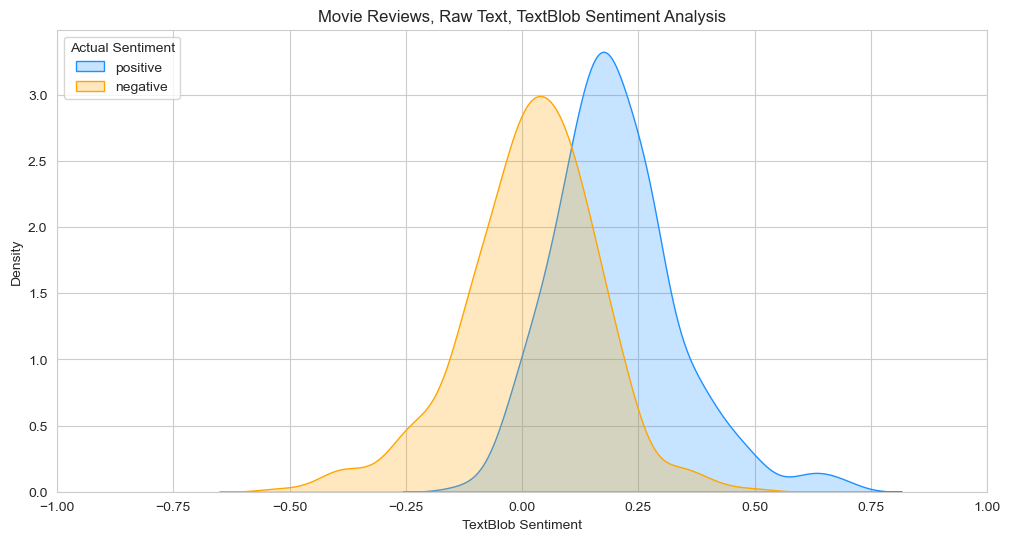

In [13]:
# visualize sentiment distribution by target class
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.kdeplot(reviews_df[reviews_df['label']==1].raw_textblob_sentiment_polarity, 
            color='dodgerblue', fill='dodgerblue', ax=ax)
sns.kdeplot(reviews_df[reviews_df['label']==0].raw_textblob_sentiment_polarity, 
            color='orange', fill='orange', ax=ax)
plt.legend(title='Actual Sentiment', loc='upper left', labels=['positive','negative'])
plt.xlabel('TextBlob Sentiment')
plt.xlim(-1,1)
plt.title('Movie Reviews, Raw Text, TextBlob Sentiment Analysis')

## Clean Text

In [14]:
# calculate sentiment
reviews_df['clean_textblob_sentiment_polarity'] = reviews_df['text_clean'].apply(
    lambda x: TextBlob(x).sentiment.polarity)

In [15]:
# review sentiment distribution by target class
reviews_df.groupby('label').clean_textblob_sentiment_polarity.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,500.0,-0.024005,0.168489,-0.634286,-0.115899,-0.014078,0.074643,0.501429
1,500.0,0.168801,0.159200,-0.352381,0.067325,0.168490,0.263889,0.900000


Text(0.5, 1.0, 'Movie Reviews, Clean Text, TextBlob Sentiment Analysis')

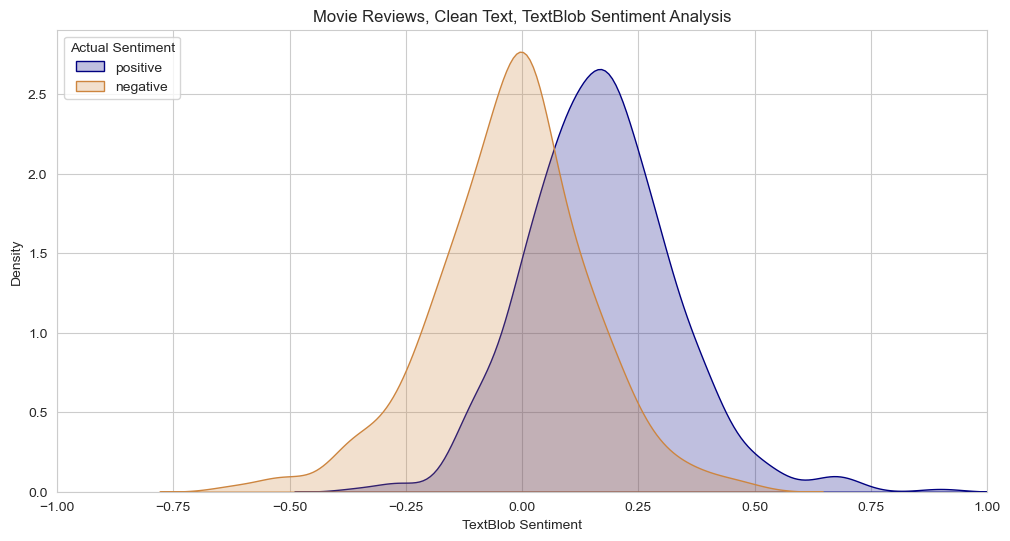

In [16]:
# visualize sentiment distribution by target class
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.kdeplot(reviews_df[reviews_df['label']==1].clean_textblob_sentiment_polarity, 
            color='navy', fill='navy', ax=ax)
sns.kdeplot(reviews_df[reviews_df['label']==0].clean_textblob_sentiment_polarity, 
            color='peru', fill='peru', ax=ax)
plt.legend(title='Actual Sentiment', loc='upper left', labels=['positive','negative'])
plt.xlabel('TextBlob Sentiment')
plt.xlim(-1,1)
plt.title('Movie Reviews, Clean Text, TextBlob Sentiment Analysis')

---
# **VADER Sentiment Analysis**

## Raw Text

In [17]:
# initialize VADER model
vader_model = SentimentIntensityAnalyzer()

In [18]:
# calculate sentiment
reviews_df['raw_vader_compound_sentiment'] = reviews_df['text'].apply(
    lambda x: vader_model.polarity_scores(x)['compound']
)

In [19]:
# review sentiment distribution by target class
reviews_df.groupby('label').raw_vader_compound_sentiment.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,500.0,0.005663,0.829579,-0.9991,-0.884950,0.11005,0.896225,0.9991
1,500.0,0.688586,0.575763,-0.9984,0.807625,0.95605,0.987625,0.9998


Text(0.5, 1.0, 'Movie Reviews, Raw Text, VADER Sentiment Analysis')

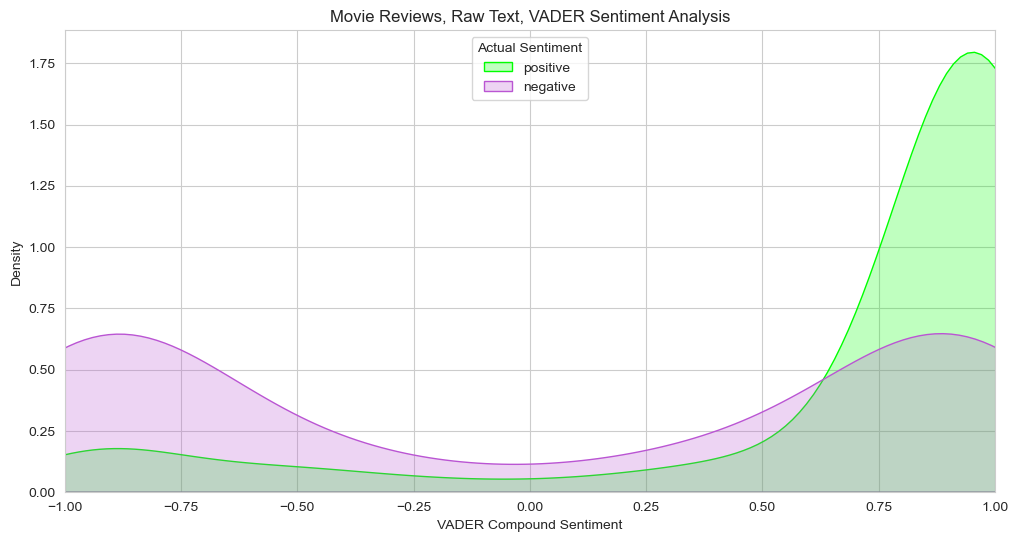

In [20]:
# visualize sentiment distribution by target class
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.kdeplot(reviews_df[reviews_df['label']==1].raw_vader_compound_sentiment, 
            color='lime', fill='lime', ax=ax)
sns.kdeplot(reviews_df[reviews_df['label']==0].raw_vader_compound_sentiment, 
            color='mediumorchid', fill='mediumorchid', ax=ax)
plt.legend(title='Actual Sentiment', loc='upper center', labels=['positive','negative'])
plt.xlabel('VADER Compound Sentiment')
plt.xlim(-1,1)
plt.title('Movie Reviews, Raw Text, VADER Sentiment Analysis')

## Clean Text

In [21]:
# calculate sentiment
reviews_df['clean_vader_compound_sentiment'] = reviews_df['text_clean'].apply(
    lambda x: vader_model.polarity_scores(x)['compound']
)

In [22]:
# review sentiment distribution by target class
reviews_df.groupby('label').clean_vader_compound_sentiment.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,500.0,-0.083324,0.793779,-0.998,-0.895575,-0.2616,0.818550,0.9976
1,500.0,0.571631,0.647235,-0.998,0.501475,0.9136,0.974975,0.9988


Text(0.5, 1.0, 'Movie Reviews, Clean Text, VADER Sentiment Analysis')

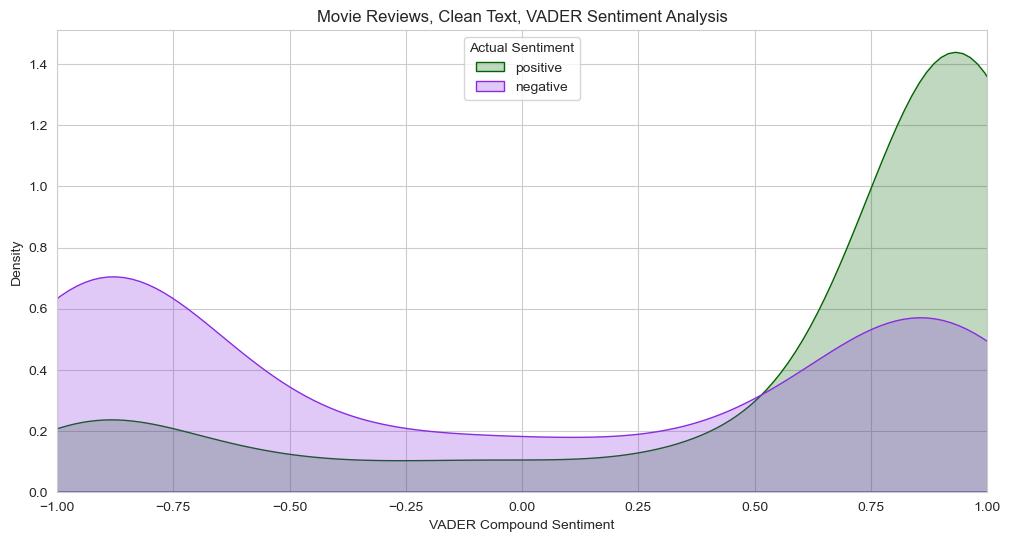

In [23]:
# visualize sentiment distribution by target class
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.kdeplot(reviews_df[reviews_df['label']==1].clean_vader_compound_sentiment, 
            color='darkgreen', fill='darkgreen', ax=ax)
sns.kdeplot(reviews_df[reviews_df['label']==0].clean_vader_compound_sentiment, 
            color='blueviolet', fill='blueviolet', ax=ax)
plt.legend(title='Actual Sentiment', loc='upper center', labels=['positive','negative'])
plt.xlabel('VADER Compound Sentiment')
plt.xlim(-1,1)
plt.title('Movie Reviews, Clean Text, VADER Sentiment Analysis')

---
# **Zero-Shot Classification**
Overview of zero shot classification from Hugging Face: https://huggingface.co/tasks/zero-shot-classification

More details on model: https://huggingface.co/facebook/bart-large-mnli

## Raw Text

In [24]:
# initialize zero shot model
zs_classifier = pipeline('zero-shot-classification', model='facebook/bart-large-mnli')

In [25]:
# calculate zero shot classification probability and print runtime
# this method is known to take a while, even for smaller datasets
positive_prob = []

start = time.time()

for idx, row in reviews_df.iterrows():
    candidate_labels = ['positive feedback', 'negative feedback']
    result = zs_classifier(row['text'], candidate_labels)
    if result['labels'][0] == 'positive feedback':
        positive_prob.append(result['scores'][0])
    else:
        positive_prob.append(result['scores'][1])
        
finish = time.time()

print(str(round(((finish-start)/60),1)) + " minutes")

17.3 minutes


In [26]:
# add zero shot results to dataframe
reviews_df['raw_zero_shot_positive_feedback_proba'] = positive_prob

In [27]:
# review probability distribution by target class
reviews_df.groupby('label').raw_zero_shot_positive_feedback_proba.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,500.0,0.181159,0.205217,0.005253,0.053513,0.100072,0.212484,0.979834
1,500.0,0.714371,0.269942,0.004732,0.557689,0.815920,0.925303,0.994154


Text(0.5, 1.0, 'Movie Reviews, Raw Text, Zero Shot Classification')

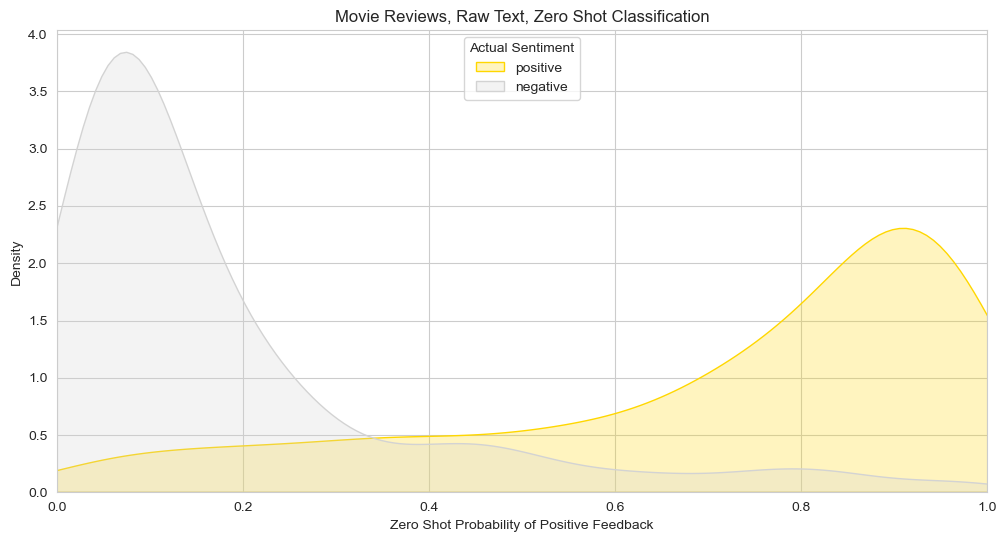

In [28]:
# visualize sentiment distribution by target class
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.kdeplot(reviews_df[reviews_df['label']==1].raw_zero_shot_positive_feedback_proba, 
            color='gold', fill='gold', ax=ax)
sns.kdeplot(reviews_df[reviews_df['label']==0].raw_zero_shot_positive_feedback_proba, 
            color='lightgray', fill='lightgray', ax=ax)
plt.legend(title='Actual Sentiment', loc='upper center', labels=['positive','negative'])
plt.xlabel('Zero Shot Probability of Positive Feedback')
plt.xlim(0,1)
plt.title('Movie Reviews, Raw Text, Zero Shot Classification')

## Clean Text

In [29]:
# calculate zero shot classification probability and print runtime
# this method is known to take a while, even for smaller datasets
positive_prob = []

start = time.time()

for idx, row in reviews_df.iterrows():
    candidate_labels = ['positive feedback', 'negative feedback']
    result = zs_classifier(row['text_clean'], candidate_labels)
    if result['labels'][0] == 'positive feedback':
        positive_prob.append(result['scores'][0])
    else:
        positive_prob.append(result['scores'][1])
        
finish = time.time()

print(str(round(((finish-start)/60),1)) + " minutes")

9.5 minutes


In [30]:
# add zero shot results to dataframe
reviews_df['clean_zero_shot_positive_feedback_proba'] = positive_prob

In [31]:
# review probability distribution by target class
reviews_df.groupby('label').clean_zero_shot_positive_feedback_proba.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,500.0,0.189546,0.294304,0.001222,0.007629,0.033307,0.230175,0.997228
1,500.0,0.634620,0.371157,0.001552,0.245206,0.795257,0.970863,0.998894


Text(0.5, 1.0, 'Movie Reviews, Clean Text, Zero Shot Classification')

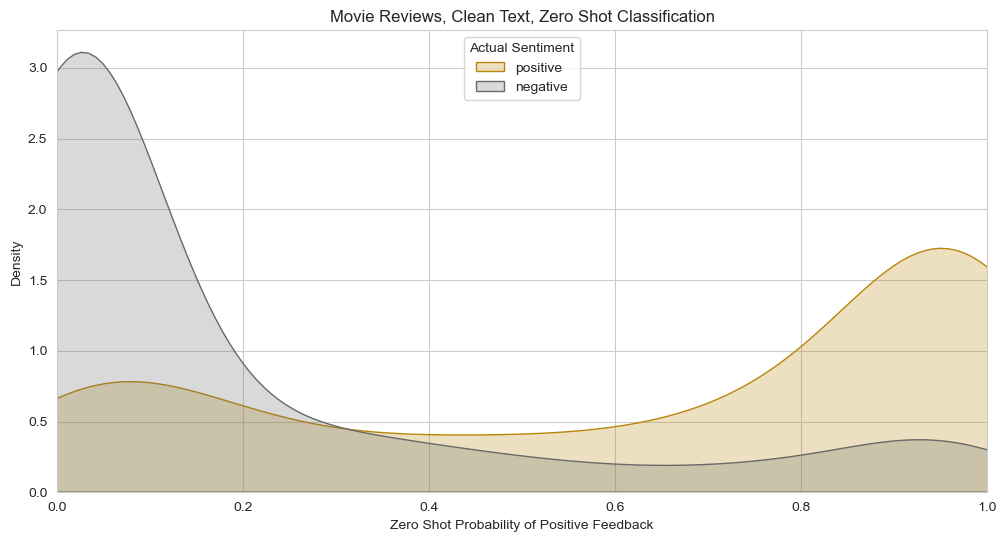

In [32]:
# visualize sentiment distribution by target class
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
sns.kdeplot(reviews_df[reviews_df['label']==1].clean_zero_shot_positive_feedback_proba, 
            color='darkgoldenrod', fill='darkgoldenrod', ax=ax)
sns.kdeplot(reviews_df[reviews_df['label']==0].clean_zero_shot_positive_feedback_proba, 
            color='dimgray', fill='dimgray', ax=ax)
plt.legend(title='Actual Sentiment', loc='upper center', labels=['positive','negative'])
plt.xlabel('Zero Shot Probability of Positive Feedback')
plt.xlim(0,1)
plt.title('Movie Reviews, Clean Text, Zero Shot Classification')

---
# **Quick Comparison using Correlation Matrix**
As a quick evaluation of the three metheods above, we will review a correlation matrix with the sentiment output and the target label (0=negative sentiment, 1=positive sentiment) from the original dataset.

In [33]:
# compute the correlation matrix
corr = reviews_df.corr()

<AxesSubplot: >

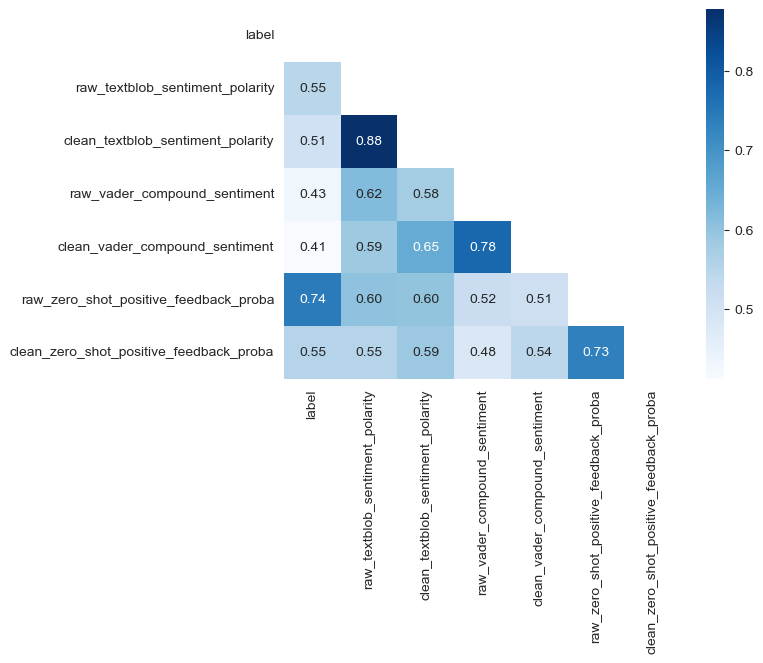

In [34]:
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=np.triu(np.ones_like(corr, dtype=bool)), annot=True, fmt='.2f', cmap='Blues')